#  Dark Matter Halo Density Calibration



## Packages

In [1]:
# conda install scikit-learn

In [2]:
#-------------importing libraries
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import forestci as fci
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from colossus.cosmology import cosmology
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from colossus.halo import profile_nfw, profile_dk14, profile_einasto
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from tensorflow.keras.optimizers import SGD, Adam, Nadam, RMSprop, Adadelta, Adagrad, Adamax, Ftrl

plt.style.use("CustomizingPlots")

2022-09-21 16:09:23.329773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/openmpi3/gcc/3.1.3/lib:/cm/shared/apps/nccl2-cuda10.2-gcc8/2.8.4/lib:/cm/shared/apps/cudnn7.6-cuda10.2/7.6.5.32/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda10.2/toolkit/10.2.89/targets/x86_64-linux/lib:/cm/local/apps/python37/lib:/cm/shared/apps/gcc8/8.4.0/lib:/cm/shared/apps/gcc8/8.4.0/lib32:/cm/shared/apps/gcc8/8.4.0/lib64:/cm/shared/apps/hdf5_18/1.8.18-mpi/lib:/cm/shared/apps/openblas/0.2.20/lib:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-09-21 16:09:23.329823: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading data

In [3]:
Final_DF_Log = pd.read_csv("Data/Data_PH_new.csv")
radial_bins_3d = pd.read_csv("Data/radial_bins.csv")
rockstar_rs_z_final = pd.read_csv("Data/Rockstar_PH_new.csv")
Final_DF_Log["index"] = Final_DF_Log.index #This column will be useful later
print("Shape of data", Final_DF_Log.shape)
Final_DF_Log.sample(n=5)

Shape of data (11167964, 13)


,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys,id,index
4828013,0.590510,29.023508,0.298649,1.835000e+13,0.382166,0.845515,0.079189,0.641222,4.024848e+12,1.804909,0.515174,18838383,4828013
6774923,0.469089,27.899910,1.127031,1.267000e+13,0.357709,1.687020,0.064268,0.528011,1.308509e+12,1.598537,1.104063,10571537,6774923
11103304,0.396826,29.386533,0.509179,1.056000e+13,0.351296,0.845515,0.069676,0.446485,5.786411e+12,1.487097,0.584531,24322452,11103304
6719196,0.414263,32.778791,-0.869113,1.023000e+13,0.339250,0.212384,0.037851,0.492976,1.720474e+14,1.513254,0.142255,27975651,6719196
6544772,0.509187,28.908440,0.363307,1.576000e+13,0.384262,0.845515,0.058593,0.530070,3.587370e+12,1.663938,0.552599,32746526,6544772


## Test halos: Selecting halos for further comparison

In [4]:
halo1_id = 21771717 
n = 3

while True:
    halo_ids = random.sample(list(np.unique(Final_DF_Log["id"])), n)
    if len(Final_DF_Log[Final_DF_Log["id"] == halo_ids[0]]) == 18 and \
    len(Final_DF_Log[Final_DF_Log["id"] == halo_ids[1]]) == 18 and \
    len(Final_DF_Log[Final_DF_Log["id"] == halo_ids[2]]) == 18:
        break
    
halo_ids.append(halo1_id)
print(halo_ids)

[15733369, 27956055, 11297699, 21771717]


In [5]:
test_halo1 = Final_DF_Log[Final_DF_Log["id"] == halo1_id]#.iloc[20:, ] #Set aside first halo
test_halo2 = Final_DF_Log[Final_DF_Log["id"] == halo_ids[0]] #Set aside second halo
test_halo3 = Final_DF_Log[Final_DF_Log["id"] == halo_ids[1]] #Set aside third halo
test_halo4 = Final_DF_Log[Final_DF_Log["id"] == halo_ids[2]] #Set aside fourth halo
print(test_halo1.shape[0] == 18)
print(test_halo2.shape[0] == 18)
print(test_halo3.shape[0] == 18)
print(test_halo4.shape[0] == 18)
test_halo1.head()

True
True
True
True


,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys,id,index
41366,1.114647,35.901513,-3.451394,3.944000e+14,1.209305,0.053348,0.169418,0.391576,3.906869e+15,3.048493,0.038337,21771717,41366
41367,1.114647,35.903883,-3.221136,3.944000e+14,1.209305,0.067162,0.169418,0.391576,3.916139e+15,3.048493,0.048263,21771717,41367
41368,1.114647,35.772720,-2.990877,3.944000e+14,1.209305,0.084552,0.169418,0.391576,3.434747e+15,3.048493,0.060760,21771717,41368
41369,1.114647,35.438623,-2.760619,3.944000e+14,1.209305,0.106444,0.169418,0.391576,2.459226e+15,3.048493,0.076492,21771717,41369
41370,1.114647,35.084319,-2.530361,3.944000e+14,1.209305,0.134005,0.169418,0.391576,1.725544e+15,3.048493,0.096297,21771717,41370


In [6]:
Final_DF_Log = Final_DF_Log[Final_DF_Log["id"] != halo1_id] #Eliminate first halo from data
Final_DF_Log = Final_DF_Log[Final_DF_Log["id"] != halo_ids[0]] #Eliminate second halo from data
Final_DF_Log = Final_DF_Log[Final_DF_Log["id"] != halo_ids[1]] #Eliminate third halo from data
Final_DF_Log = Final_DF_Log[Final_DF_Log["id"] != halo_ids[2]] #Eliminate fourth halo from data
Final_DF_Log[["Mvir_Msun.h", "rmid_Rvir", "Density"]].head()

,Mvir_Msun.h,rmid_Rvir,Density
0,6.513000e+13,-2.877325,36.474184
1,6.513000e+13,-2.647067,36.571866
2,6.513000e+13,-2.416808,36.048141
3,6.513000e+13,-2.186550,35.095003
4,6.513000e+13,-1.956292,35.146164


After removing the halos from the data set, we check to see if those halos were actually elimated from the data. Below we search for the halos IDs to make sure they are not in the data.

In [7]:
for i in halo_ids:
    if i in list(Final_DF_Log["id"]):
        print(i, "found")
    else:
        print(i, "not found")

15733369 not found
27956055 not found
11297699 not found
21771717 not found


## Reshuffling the data

In [8]:
#-------------Reshuffle data
Final_DF_Log_reshuffle = shuffle(Final_DF_Log, random_state=0).iloc[:100000, :]
Final_DF_Log_reshuffle.head()

,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys,id,index
4208924,0.563684,34.001397,-1.431290,2.875000e+13,0.498910,0.168702,0.143147,0.414815,5.842776e+14,1.757133,0.119240,32525470,4208924
1231615,0.777353,28.832196,0.684762,4.532000e+13,0.508617,1.687020,0.114735,0.672405,3.324020e+12,2.175706,1.008739,33265042,1231615
913928,0.882409,33.727244,-1.361463,8.494000e+13,0.642285,0.267375,0.220210,0.624311,4.441768e+14,2.416715,0.164608,12227803,913928
9889817,0.362256,31.315057,-0.447879,1.266000e+13,0.400958,0.336606,0.120455,0.313815,3.980673e+13,1.436567,0.256205,3092586,9889817
9324627,0.362240,27.891376,1.396266,1.256000e+13,0.399290,2.123840,0.046546,0.316566,1.297390e+12,1.436543,1.613166,10181504,9324627


## Train-test split

In [9]:
#-------------Separate Target Variable and Predictor Variables
TargetVar=["Density"]
X = Final_DF_Log_reshuffle#.values
y = Final_DF_Log_reshuffle[TargetVar]#.values


#-------------Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Data visualization and descriptive statistics

In [10]:
data = X_train
data[["Mvir_Msun.h", "Rvir_Mpc.h", "r_mid"]] = np.log(X_train[["Mvir_Msun.h", "Rvir_Mpc.h", "r_mid"]])

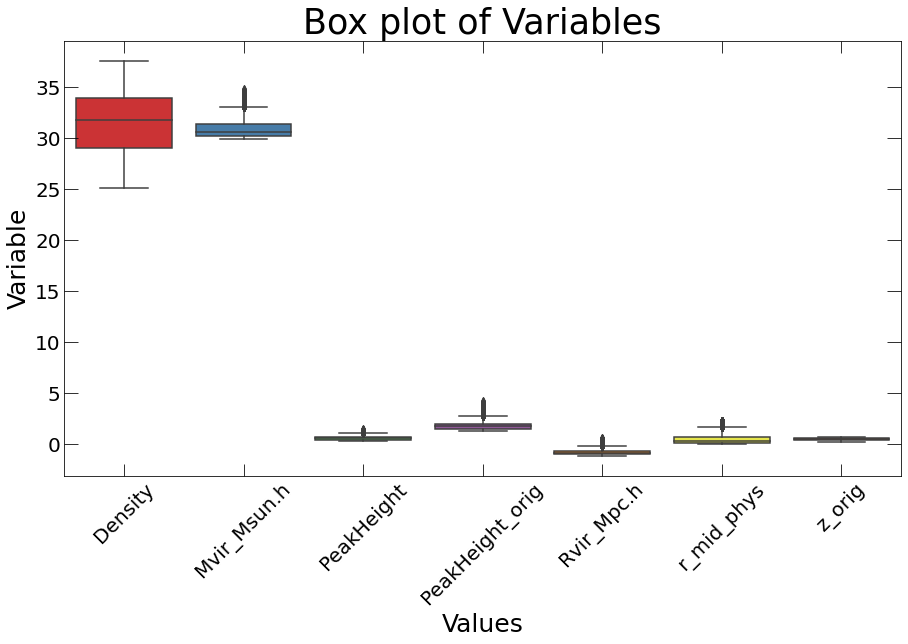

In [11]:
plt.figure(figsize = (15,8))
sns.boxplot(data = data[["Density", "Mvir_Msun.h","PeakHeight", 
                         "PeakHeight_orig", "Rvir_Mpc.h", 
                         "r_mid_phys", "z_orig"]], palette="Set1")
plt.xlabel("Values")
plt.ylabel("Variable")
plt.xticks(rotation = 45)
plt.title("Box plot of Variables")
plt.show()

### Pair plot 

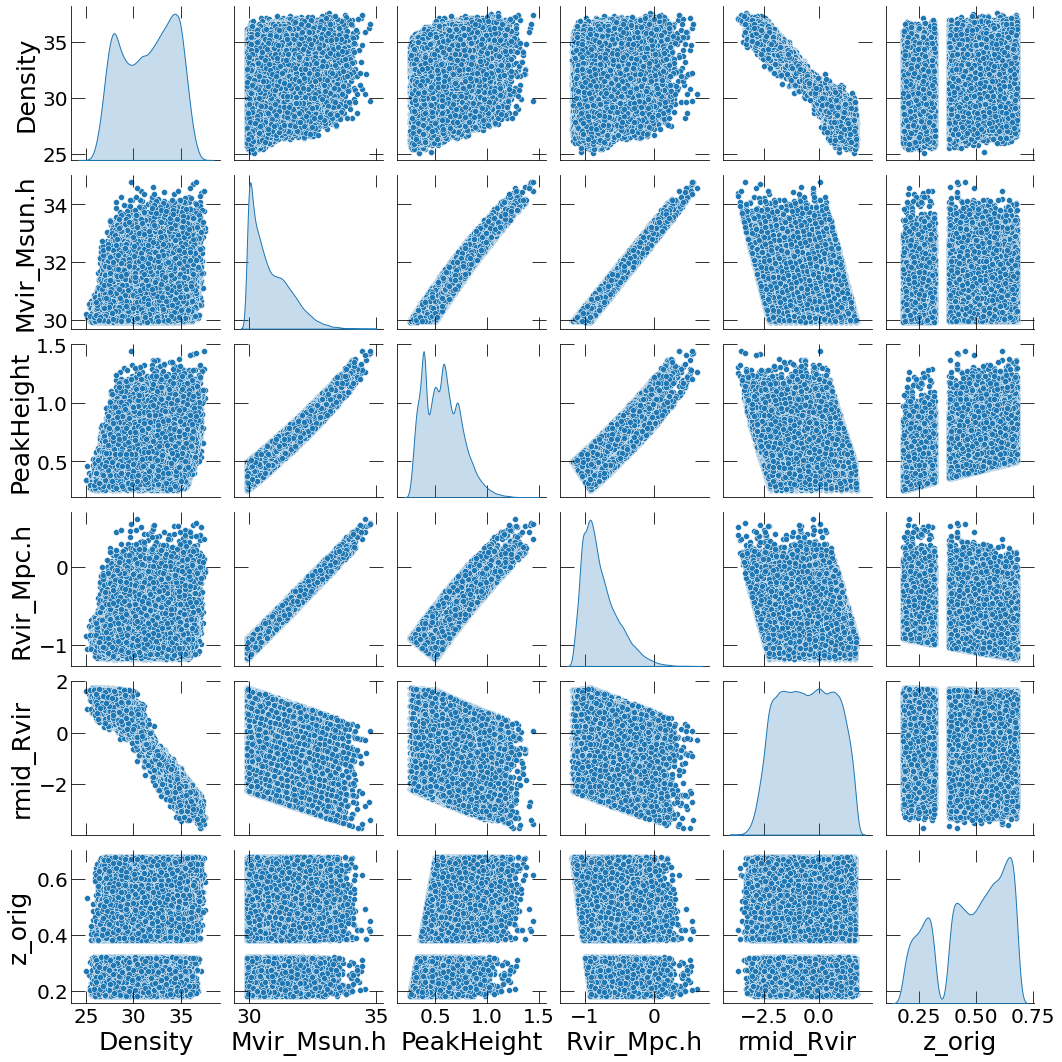

In [12]:
sns.pairplot(data[["Density", "Mvir_Msun.h","PeakHeight", "Rvir_Mpc.h", 
                         "rmid_Rvir", "z_orig"]], diag_kind='kde')
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=12, top = True, right = True, rotation = 45)
plt.show()

### Descriptive statistics

In [13]:
X_train.drop(["id", "index"], axis = 1).describe()

,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000
mean,0.568136,31.500288,-0.551792,30.826397,-0.781416,-0.947692,0.111258,0.477726,5.449331e+14,1.794160,0.491929
std,0.178224,2.774142,1.214409,0.769049,0.252032,1.182066,0.083506,0.144709,1.155939e+15,0.337979,0.522180
min,0.253665,25.063833,-3.689865,29.934606,-1.181155,-2.930911,0.011766,0.180059,7.675105e+10,1.288740,0.031758
25%,0.407477,28.999970,-1.574228,30.182807,-0.968332,-2.009878,0.058749,0.388166,3.931218e+12,1.503021,0.094443
50%,0.561170,31.733152,-0.546775,30.613161,-0.842292,-0.858586,0.085834,0.504385,6.046898e+13,1.752723,0.264519
75%,0.694136,33.920412,0.480969,31.322896,-0.644352,0.062449,0.133192,0.603076,5.388251e+14,2.001978,0.724458
max,1.445136,37.552995,1.732085,34.778580,0.612039,0.983482,1.167020,0.679998,2.037317e+16,4.242431,2.264932


## Error bars from actual data

In [14]:
#-------------Error bars from actual data
actual_err_bars = X_train[["r_mid", "Density"]].groupby(["r_mid"]).std().values.reshape(1,-1)[0]
actual_err_bars

array([0.65587596, 0.69333583, 0.70726332, 0.70914697, 0.70258932,
       0.71572747, 0.71945979, 0.72528439, 0.77006231, 0.81044087,
       0.86835474, 0.93481817, 1.02877925, 1.03029683, 0.96512887,
       0.8950322 , 0.80295664, 0.76991779])

## Data standardization

In [15]:
X_test_actual = pd.DataFrame(X_test) # keeping a copy of X test data before tranforming it. 
                                     # This will be needs later
y_test_actual = y_test.values.reshape(1,-1)[0] # Keeping a copy of y test data before transforming it. 
                                               # This will be used to compare predictions.
X_train = pd.DataFrame(X_train)[["PeakHeight", "rmid_Rvir"]].values
X_test = pd.DataFrame(X_test)[["PeakHeight", "rmid_Rvir"]].values


#-------------Standardization of data
PredictorScaler=MaxAbsScaler()
TargetVarScaler=MaxAbsScaler()

# PredictorScaler=RobustScaler()
# TargetVarScaler=RobustScaler()

# PredictorScaler=StandardScaler()
# TargetVarScaler=StandardScaler()

# PredictorScaler=MinMaxScaler()
# TargetVarScaler=MinMaxScaler()

#-------------Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X_train)
TargetVarScalerFit=TargetVarScaler.fit(y_train)

#-------------Generating the standardized values of X and y
X_train=PredictorScalerFit.transform(X_train)
X_test=PredictorScalerFit.transform(X_test)
y_train=TargetVarScalerFit.transform(y_train)
y_test=TargetVarScalerFit.transform(y_test)


#-------------Quick sanity check with the shapes of Training and testing datasets
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (80000, 2)
y_train (80000, 1)
X_test (20000, 2)
y_test (20000, 1)


## Preparing test halos

In [16]:
Test_halo_target=["Density"]

#-------------First test halo
X_test_halo1 = test_halo1[["PeakHeight", "rmid_Rvir"]].values
y_test_halo1 = test_halo1[Test_halo_target].values.reshape(1,-1)[0]

#-------------Second test halo
X_test_halo2 = test_halo2[["PeakHeight", "rmid_Rvir"]].values
y_test_halo2 = test_halo2[Test_halo_target].values.reshape(1,-1)[0]

#-------------Third test halo
X_test_halo3 = test_halo3[["PeakHeight", "rmid_Rvir"]].values
y_test_halo3 = test_halo3[Test_halo_target].values.reshape(1,-1)[0]

#-------------Fourth test halo
X_test_halo4 = test_halo4[["PeakHeight", "rmid_Rvir"]].values
y_test_halo4 = test_halo4[Test_halo_target].values.reshape(1,-1)[0]

#-------------Generating the standardized values of X and y
X_test_halo1=PredictorScalerFit.transform(X_test_halo1)
X_test_halo2=PredictorScalerFit.transform(X_test_halo2)
X_test_halo3=PredictorScalerFit.transform(X_test_halo3)
X_test_halo4=PredictorScalerFit.transform(X_test_halo4)


#-------------Turning the data into appropriate format and picking only the needed columns
X_test_halo1=pd.DataFrame(X_test_halo1).values
X_test_halo2=pd.DataFrame(X_test_halo2).values
X_test_halo3=pd.DataFrame(X_test_halo3).values
X_test_halo4=pd.DataFrame(X_test_halo4).values

print(X_test_halo1.shape)
print(y_test_halo1.shape)
print(X_test_halo2.shape)
print(y_test_halo2.shape)
print(X_test_halo3.shape)
print(y_test_halo3.shape)
print(X_test_halo4.shape)
print(y_test_halo4.shape)

(18, 2)
(18,)
(18, 2)
(18,)
(18, 2)
(18,)
(18, 2)
(18,)


# Machine learning methodology
## Random Forest (RF)

In [17]:
%%time

model_rf = RandomForestRegressor(n_estimators=800, min_samples_leaf=1)
model_rf.fit(X_train, y_train.ravel())

CPU times: user 2min 15s, sys: 1.64 s, total: 2min 17s
Wall time: 2min 17s


RandomForestRegressor(n_estimators=800)

### Random Forest predictions

In [18]:
y_pred_rf = model_rf.predict(X_test)
# y_pred_rf
Actual_predictions_rf = TargetVarScaler.inverse_transform(y_pred_rf.reshape(1, -1))[0]
# Actual_predictions_rf = pd.DataFrame(Actual_predictions[0])
Actual_predictions_rf

array([32.54015385, 34.26870734, 33.77555856, ..., 34.9927787 ,
       27.84115856, 34.15225241])

## Computing error bars

In [19]:
#-------------Calculate the standard deviation on predictions
err_bars_rf = fci.random_forest_error(model_rf, X_train, X_test)
err_bars_rf
pred_err_bars_rf = TargetVarScaler.inverse_transform(np.array(np.sqrt(err_bars_rf)).reshape(1, -1))
pred_err_bars_rf

array([[0.52088428, 0.5071416 , 0.52094332, ..., 0.56804315, 0.48202471,
        0.55090894]])

## Test halo prediction (RF)

In [20]:
#Error bars on test halos (RF)

#-------------First halo
halo1_pred_rf = model_rf.predict(X_test_halo1)
test_halo_pred1_rf = TargetVarScaler.inverse_transform(halo1_pred_rf.reshape(1, -1))[0]

#-------------Second halo
halo2_pred_rf = model_rf.predict(X_test_halo2)
test_halo_pred2_rf = TargetVarScaler.inverse_transform(halo2_pred_rf.reshape(1, -1))[0]

#-------------Third halo
halo3_pred_rf = model_rf.predict(X_test_halo3)
test_halo_pred3_rf = TargetVarScaler.inverse_transform(halo3_pred_rf.reshape(1, -1))[0]

#-------------Fourth halo
halo4_pred_rf = model_rf.predict(X_test_halo4)
test_halo_pred4_rf = TargetVarScaler.inverse_transform(halo4_pred_rf.reshape(1, -1))[0]

In [21]:
test_halo_pred1_rf

array([36.50522381, 36.55281032, 36.22803478, 35.86115165, 35.76895448,
       35.3140645 , 35.15420838, 34.53239702, 34.13117931, 33.72826993,
       33.1617011 , 32.57543856, 32.11225036, 31.57080619, 31.11185003,
       30.14947636, 29.49211356, 28.44285779])

### Error bars for test halo predictions (DE)

In [22]:
#Error bars on test halos
err_bars1_rf = fci.random_forest_error(model_rf, X_train, X_test_halo1)
err_bars2_rf = fci.random_forest_error(model_rf, X_train, X_test_halo2)
err_bars3_rf = fci.random_forest_error(model_rf, X_train, X_test_halo3)
err_bars4_rf = fci.random_forest_error(model_rf, X_train, X_test_halo4)

err_bars1_rf = TargetVarScaler.inverse_transform(np.array(np.sqrt(np.abs(err_bars1_rf)).reshape(1, -1)))[0]
err_bars2_rf = TargetVarScaler.inverse_transform(np.array(np.sqrt(np.abs(err_bars2_rf)).reshape(1, -1)))[0]
err_bars3_rf = TargetVarScaler.inverse_transform(np.array(np.sqrt(np.abs(err_bars3_rf)).reshape(1, -1)))[0]
err_bars4_rf = TargetVarScaler.inverse_transform(np.array(np.sqrt(np.abs(err_bars4_rf)).reshape(1, -1)))[0]
err_bars1_rf

No calibration with n_samples <= 20:  consider using more n_estimators in your model,  for more accurate ci and to avoid negative values.
No calibration with n_samples <= 20:  consider using more n_estimators in your model,  for more accurate ci and to avoid negative values.
No calibration with n_samples <= 20:  consider using more n_estimators in your model,  for more accurate ci and to avoid negative values.
No calibration with n_samples <= 20:  consider using more n_estimators in your model,  for more accurate ci and to avoid negative values.


array([0.80501283, 0.37539046, 0.09819053, 0.14153983, 0.24564039,
       0.17088972, 0.20044288, 0.09794616, 0.06402274, 0.12907109,
       0.22469172, 0.08807254, 0.35305761, 0.13901703, 0.09441884,
       0.35675574, 0.64054296, 0.19119116])

## Model Diagnostics
All model diagnostics are based on the test set.

### Actual vs predicted plot

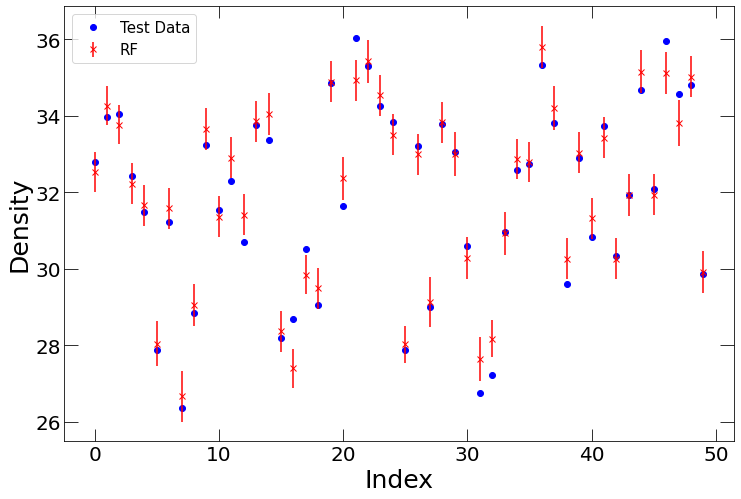

In [23]:
plt.figure(figsize=(12,8))

#-------------Test Data
plt.plot(y_test_actual[0:50], "ob", 
        label = "Test Data")

#-------------RF
plt.errorbar(
    list(range(50)),
    Actual_predictions_rf[0:50],
    yerr=(pd.DataFrame(pred_err_bars_rf).T)[0][:50], fmt='x',
    color = "red", label = "RF"
)

#-------------Figure labels
plt.xlabel("Index")
plt.ylabel("Density")
plt.legend(fontsize=15)
plt.show()

Text(0, 0.5, 'Predicted')

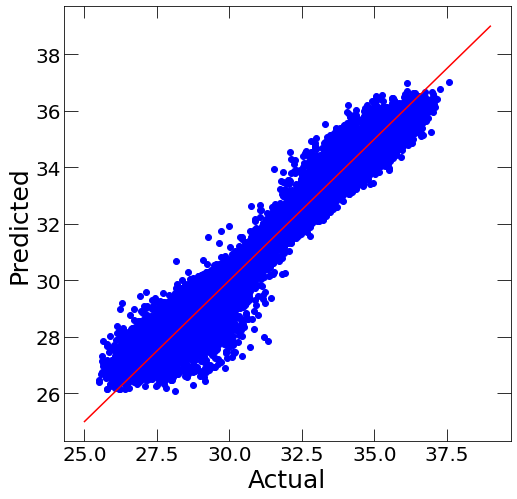

In [24]:
#-------------Actual vs predicted scatter plot (RF)
plt.figure(figsize = (8,8))
xx = np.linspace(25, 39)
plt.plot(xx,xx, color = "red")
plt.scatter(y_test_actual, Actual_predictions_rf, color="blue")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.title("Actual vs Predicted RF")

### Correlation plot

We expect to see a high positive correlation between the actual and predicted values.


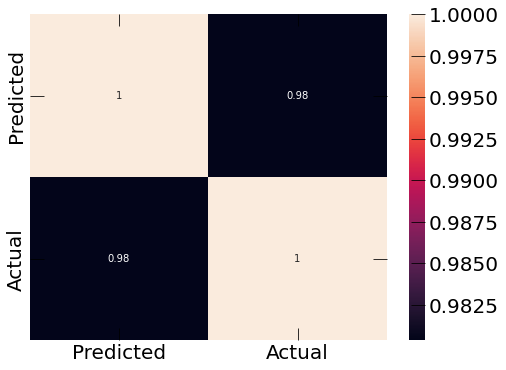

In [25]:
plt.figure(figsize = (8,6))
cor_rf = pd.DataFrame(Actual_predictions_rf).rename(columns = {0:"Predicted"})\
.join(pd.DataFrame(y_test_actual, columns = ['Actual']))

corrMatrix_rf = cor_rf.corr()
sns.heatmap(corrMatrix_rf, annot=True)
# plt.title("RF")
plt.show()

### Histogram of errors
Ideally, we expect the error on all predictions to be very close to zero. The more they are close to zero, the more our predictions are close to the actual values. We also expect the distribution of errors to be Gaussian.

Text(0, 0.5, 'Count')

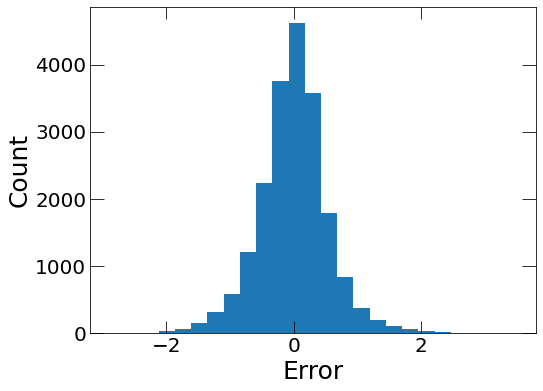

In [26]:
#-------------Histogram of errors (RF)
plt.figure(figsize = (8,6))
# yy_rf = np.abs(y_test_actual-Actual_predictions_rf)
yy_rf = y_test_actual-Actual_predictions_rf
plt.hist(yy_rf, bins = 25)
plt.xlabel("Error")
plt.ylabel("Count")
# plt.title("Prediction Errors (RF)")

### Measuring model goodness of fit

In [27]:
# Measuring Goodness of fit in test data (RF)
print("Measuring Goodness of fit in test data (RF):")
#-------------Adj. R2 
print('Adj. R2 Value RF:', metrics\
      .r2_score(y_test_actual, Actual_predictions_rf))

#-------------Mean Absolute Error
print("Mean Absolute Error:", metrics\
      .mean_absolute_error(Actual_predictions_rf, y_test_actual))

#-------------Mean Squared Error
print("Mean Squared Error:", metrics\
      .mean_squared_error(Actual_predictions_rf,y_test_actual))

#-------------Root Mean Squared Error
print("Root Mean Squared Error:", math\
      .sqrt(metrics.mean_squared_error(Actual_predictions_rf,y_test_actual)))

#-------------Mean Absolute Percentage Error
print("Mean Absolute Percentage Error:", 
      np.mean(100*(np.abs(y_test_actual-Actual_predictions_rf)/y_test_actual)))


Measuring Goodness of fit in test data (RF):
Adj. R2 Value RF: 0.9610853083586627
Mean Absolute Error: 0.4031271080809978
Mean Squared Error: 0.2975670102668655
Root Mean Squared Error: 0.5454970304840032
Mean Absolute Percentage Error: 1.3087149689654638


### Test halo prediction (RF)

In [28]:
test_halo_predictions1 = model_rf.predict(X_test_halo1) 
test_halo_Actual_predictions1 = TargetVarScaler.inverse_transform(test_halo_predictions1.reshape(1, -1))

test_halo_predictions2 = model_rf.predict(X_test_halo2)
test_halo_Actual_predictions2 = TargetVarScaler.inverse_transform(test_halo_predictions2.reshape(1, -1))

test_halo_predictions3 = model_rf.predict(X_test_halo3)
test_halo_Actual_predictions3 = TargetVarScaler.inverse_transform(test_halo_predictions3.reshape(1, -1))

test_halo_predictions4 = model_rf.predict(X_test_halo4)
test_halo_Actual_predictions4 = TargetVarScaler.inverse_transform(test_halo_predictions4.reshape(1, -1))
# test_halo_Actual_predictions1

### Extracting test halo properties

Now, we will extract all the needed halo properties for our test halos from the `BigRockstar_PH2.csv` data set. These will be used in fitting the analytic models. 

In [29]:
#-------------First halo
Mvir = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][1] 
cvir = (rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][3])\
/(rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][5])
Rvir = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][3]
z = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][2] 
r = radial_bins_3d["r_mid"]/(1+z)

#-------------Second halo
Mvir2 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][1]
cvir2 = (rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][3])\
/(rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][5])
Rvir2 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][3]
z2 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][2]
r2 = radial_bins_3d["r_mid"]/(1+z2)

#-------------Third halo
Mvir3 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][1]
cvir3 = (rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][3])\
/(rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][5])
Rvir3 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][3]
z3 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][2]
r3 = radial_bins_3d["r_mid"]/(1+z3)

#-------------Fourth halo
Mvir4 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][1]
cvir4 = (rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][3])\
/(rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][5])
Rvir4 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][3]
z4 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][2]
r4 = radial_bins_3d["r_mid"]/(1+z4)

### Fitting analytic profile models

Now, we set cosmology for the analytic models. We also fit three analytic models to the test halos. They include NFW, Einasto, and DK14 density profiles. 

In [30]:
#Setting Cosmology.
params = {'flat': True, 'H0': 70, 'Om0': 0.286, 'Ob0': 0.046, 'sigma8': 0.82, 'ns': 0.96}
cosmo = cosmology.setCosmology('my_cosmo', params)
print(cosmo)

#-------------First halo
p_dk14 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir, c = cvir, z = z, 
                                                   mdef = 'vir', 
                                                   outer_term_names = ['pl'])
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_einasto = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
rho_dk14 = p_dk14.density(r*1000)
rho_nfw = p_nfw.density(r*1000)
rho_einasto = p_einasto.density(r*1000)

#-------------Second halo
p_dk14_2 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir2, c = cvir2, z = z2, 
                                                     mdef = 'vir', 
                                                     outer_term_names = ['pl'])
p_nfw_2 = profile_nfw.NFWProfile(M = Mvir2, c = cvir2, z = z2, mdef = 'vir')
p_einasto_2 = profile_einasto.EinastoProfile(M = Mvir2, c = cvir2, z = z2, mdef = 'vir')
rho_dk14_2 = p_dk14_2.density(r2*1000)
rho_nfw_2 = p_nfw_2.density(r2*1000)
rho_einasto_2 = p_einasto_2.density(r2*1000)

#-------------Third halo
p_dk14_3 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir3, c = cvir3, z = z3, 
                                                     mdef = 'vir', 
                                                   outer_term_names = ['pl'])
p_nfw_3 = profile_nfw.NFWProfile(M = Mvir3, c = cvir3, z = z3, mdef = 'vir')
p_einasto_3 = profile_einasto.EinastoProfile(M = Mvir3, c = cvir3, z = z3, mdef = 'vir')
rho_dk14_3 = p_dk14_3.density(r3*1000)
rho_nfw_3 = p_nfw_3.density(r3*1000)
rho_einasto_3 = p_einasto_3.density(r3*1000)

#-------------Fourth halo
p_dk14_4 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir4, c = cvir4, z = z4, 
                                                     mdef = 'vir', 
                                                   outer_term_names = ['pl'])
p_nfw_4 = profile_nfw.NFWProfile(M = Mvir4, c = cvir4, z = z4, mdef = 'vir')
p_einasto_4 = profile_einasto.EinastoProfile(M = Mvir4, c = cvir4, z = z4, mdef = 'vir')
rho_dk14_4 = p_dk14_4.density(r4*1000)
rho_nfw_4 = p_nfw_4.density(r4*1000)
rho_einasto_4 = p_einasto_4.density(r4*1000)

Cosmology "my_cosmo" 
    flat = True, Om0 = 0.2860, Ode0 = 0.7139, Ob0 = 0.0460, H0 = 70.00, sigma8 = 0.8200, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


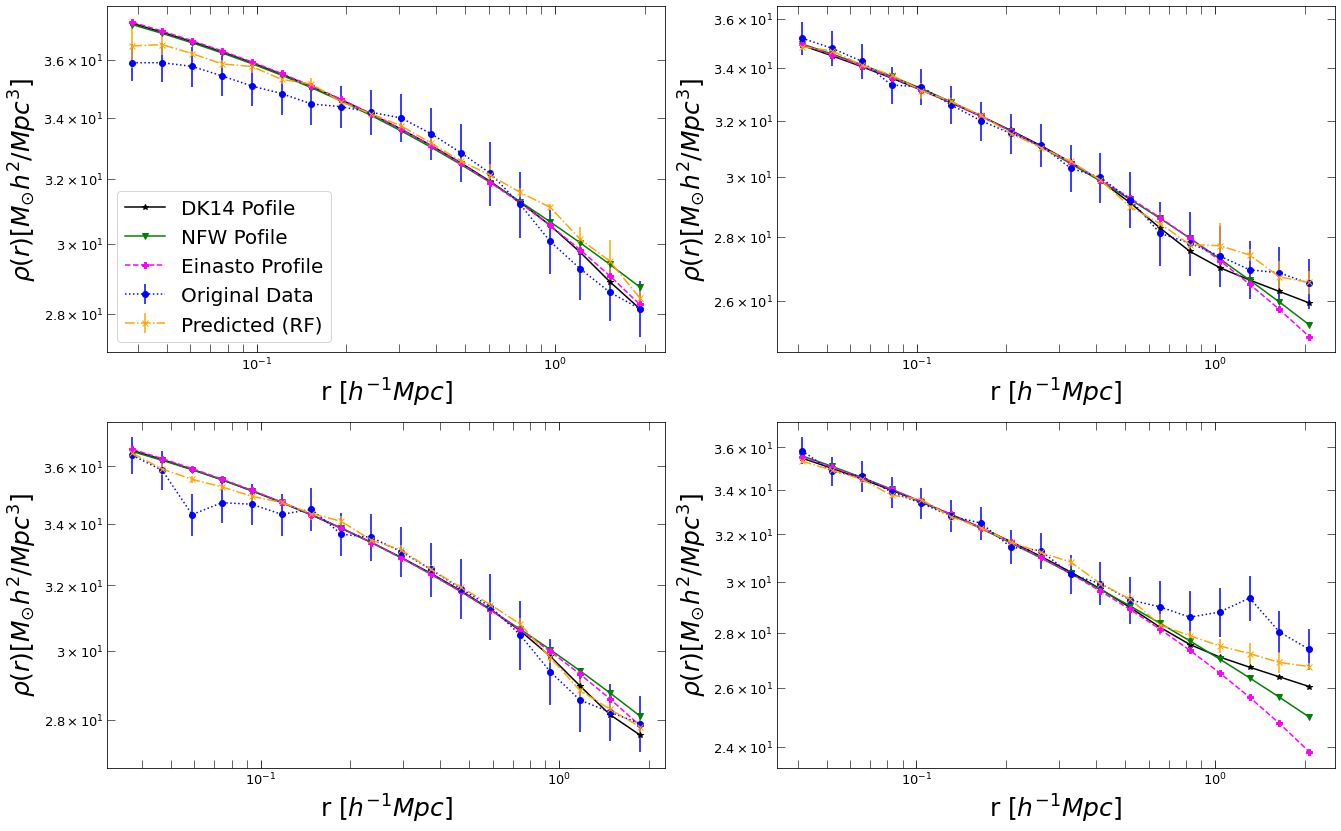

In [31]:
#Comparing plots: Visual comparison

########################
########################
#-------------First halo-------------#
plt.figure(figsize = (22,14))
plt.subplot(2, 2, 1)
plt.xlabel(r"r [$h^{-1}Mpc$]")
plt.ylabel(r"$\rho(r) [M_{\odot}h^2/Mpc^3]$")
plt.loglog()


#-------------Original Data
plt.errorbar(
    r,
    y_test_halo1,
    yerr=actual_err_bars, fmt='o', linestyle='dotted', 
    label = "Original Data", color = "blue"
)


#-------------Predicted (RF)
plt.errorbar(
    r,
    test_halo_pred1_rf,
#     xerr=0.01,
    yerr=err_bars1_rf, fmt='x', linestyle='dashdot', 
    label = "Predicted (RF)", color = "orange"
)


#-------------Analytic density profiles
plt.plot(r, np.log(rho_dk14*1e9), '-', 
         label = 'DK14 Pofile', color = "black", marker="*") #DK14
plt.plot(r, np.log(rho_nfw*1e9), '-', 
         label = 'NFW Pofile', color = "green", marker="v") #NFW
plt.plot(r, np.log(rho_einasto*1e9), '--', 
         label = 'Einasto Profile', color = "magenta", marker="P") #Einasto
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=13, top = True, right = True)
plt.legend()


########################
########################
#-------Second halo-------------#
plt.subplot(2, 2, 2)
plt.xlabel(r"r [$h^{-1}Mpc$]")
plt.ylabel(r"$\rho(r) [M_{\odot}h^2/Mpc^3]$")
plt.loglog()

#-------------Original data
plt.errorbar(
    r2,
    y_test_halo2,
    yerr=actual_err_bars, fmt='o', linestyle='dotted', 
    label = "Original Data", color = "blue"
)


#-------------Predicted (RF)
plt.errorbar(
    r2,
    test_halo_pred2_rf,
    yerr=err_bars2_rf, fmt='x', linestyle='dashdot', 
    label = "Predicted (RF)", color = "orange"
)


#-------------Analytic density profiles
plt.plot(r2, np.log(rho_dk14_2*1e9), '-', 
         label = 'DK14 Pofile', color = "black", marker="*") #DK14
plt.plot(r2, np.log(rho_nfw_2*1e9), '-', 
         label = 'NFW Pofile', color = "green", marker="v") #NFW
plt.plot(r2, np.log(rho_einasto_2*1e9), '--', 
         label = 'Einasto Profile', color = "magenta", marker="P") #Einasto
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=13, top = True, right = True)


############################################################
############################################################
#-------Third halo-------------#
plt.subplot(2, 2, 3)
plt.rc("axes")
plt.xlabel(r"r [$h^{-1}Mpc$]")
plt.ylabel(r"$\rho(r) [M_{\odot}h^2/Mpc^3]$")
plt.loglog()

#-------------Original data
plt.errorbar(
    r3,
    y_test_halo3,
    yerr=actual_err_bars, fmt='o', linestyle='dotted', 
    label = "Original Data", color = "blue"
)


#-------------Predicted (MCD)
plt.errorbar(
    r3,
    test_halo_pred3_rf,
    yerr=err_bars3_rf, fmt='x', linestyle='dashdot', 
    label = "Predicted (RF)", color = "orange"
)


#-------------Analytic density profiles
plt.plot(r3, np.log(rho_dk14_3*1e9), '-', 
         label = 'DK14 Pofile', color = "black", marker="*") #DK14
plt.plot(r3, np.log(rho_nfw_3*1e9), '-', 
         label = 'NFW Pofile', color = "green", marker="v") #NFW
plt.plot(r3, np.log(rho_einasto_3*1e9), '--', 
         label = 'Einasto Profile', color = "magenta", marker="P") #Einasto
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=13, top = True, right = True)


############################################################
############################################################
#-------Fourth halo-------------#
plt.subplot(2, 2, 4)
plt.xlabel(r"r [$h^{-1}Mpc$]")
plt.ylabel(r"$\rho(r) [M_{\odot}h^2/Mpc^3]$")
plt.loglog()


#-------Original data
plt.errorbar(
    r4,
    y_test_halo4,
    yerr=actual_err_bars, fmt='o', linestyle='dotted', 
    label = "Original Data", color = "blue"
)


#-------------Predicted (RF)
plt.errorbar(
    r4,
    test_halo_pred4_rf,
    yerr=err_bars4_rf, fmt='x', linestyle='dashdot',
    label = "Predicted (MCD)", color = "orange"
)

#-------------Analytic density profiles
plt.plot(r4, np.log(rho_dk14_4*1e9), '-', 
         label = 'DK14 Pofile', color = "black", marker="*") #DK14
plt.plot(r4, np.log(rho_nfw_4*1e9), '-', 
         label = 'NFW Pofile', color = "green", marker="v") #NFW
plt.plot(r4, np.log(rho_einasto_4*1e9), '--', 
         label = 'Einasto Profile', color = "magenta", marker="P") #Einasto
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=13, top = True, right = True)

plt.show()

### Generalized MSE

In [32]:
#-------------RF
a_rf=((y_test_actual - Actual_predictions_rf)**2/pred_err_bars_rf.ravel()**2).sum()
b_rf=len(y_test)-800
chi_sq_rf = a_rf/b_rf
chi_sq_rf

1.0279070962049537

### Computing mean squared error (MSE)

In [33]:
X_test_actual = pd.DataFrame(X_test_actual)
X_test_actual.columns = Final_DF_Log_reshuffle.columns

X_test_actual["id"] = X_test_actual["id"].astype("int64")
X_test_actual.head()

,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys,id,index
8211877,0.441048,32.793824,-0.954210,1.348000e+13,0.380674,0.212384,0.063616,0.448693,1.746533e+14,1.554336,0.146604,11962009,8211877
6758618,0.414603,33.983772,-1.811581,1.105000e+13,0.352900,0.084552,0.076077,0.466322,5.740697e+14,1.513770,0.057662,27775400,6758618
2359237,0.804852,34.064022,-1.462282,5.750000e+13,0.562306,0.212384,0.172264,0.630083,6.220379e+14,2.236366,0.130290,5758604,2359237
10245460,0.343405,32.422697,-0.954356,1.577000e+13,0.459951,0.212384,0.037458,0.199173,1.205032e+14,1.409739,0.177109,10087558,10245460
8120900,0.437526,31.481237,-0.631037,2.291000e+13,0.506366,0.336606,0.053321,0.249435,4.700320e+13,1.548870,0.269407,2773263,8120900


### NFW and Einasto predictions on the whole test set

Here we use the NFW and Einasto predictions on the entire test set.

In [34]:
%%time

Mvir = X_test_actual.loc[:, "Mvir_Msun.h"]
Rvir = X_test_actual.loc[:, "Rvir_Mpc.h"]
rs = X_test_actual.loc[:, "rs"]
z_orig = X_test_actual.loc[:, "z_orig"]
r_mid = X_test_actual.loc[:, "r_mid"]/(1+X_test_actual.loc[:, "z_orig"])
cvir = Rvir/rs
p_nfw_5 = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z_orig, mdef = 'vir')

p_einasto_5 = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = z_orig, mdef = 'vir')

rho_nfw_5 = p_nfw_5.density(r_mid*1000)*1e9
rho_einasto_5 = p_einasto_5.density(r_mid*1000)*1e9

CPU times: user 57.9 ms, sys: 2.77 ms, total: 60.6 ms
Wall time: 59.6 ms


### The MSE's

In [35]:
#-------------Computing MSE's
NFW_mse = ((y_test_actual - np.array(np.log(rho_nfw_5)))**2).sum()/len(y_test)
Einasto_mse = ((y_test_actual - np.array(np.log(rho_einasto_5)))**2).sum()/len(y_test)
mse_rf = ((y_test_actual - Actual_predictions_rf)**2).sum()/len(y_test)

#-------------Print them
print(f"MSE for Einasto Profile is: {Einasto_mse}")
print(f"MSE for NFW Profile is: {NFW_mse}")
print(f"MSE for RF Model is: {mse_rf}")

MSE for Einasto Profile is: 0.5164138522664408
MSE for NFW Profile is: 0.3819775639690343
MSE for RF Model is: 0.2975670102668655


# THE END.